# Projekt numer 1 Szymon Kwieciński
Przedmiot: Zarządzanie i harmonogramowanie procesów (2024L)
Karta przedmiotu: 639B-INSWS-MEP-ZHPUZ  
Prowadzący:
    ...
Wykonał: Szymon Kwieciński nr. albumu ...  
Data: 12.03.2024  

Mail dla którego zostały podane dane dla zadania: ... 


# Table of Contents  
1. [Dane](#dane)
2. [Zadanie 1](#z_1)
3. [Zadanie 2](#z_2)
4. [Zadanie 3](#z_3)
5. [Zadanie 4](#z_4)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from amplpy import AMPL, ampl_notebook
import os
from functools import partial
from dotenv import load_dotenv

In [3]:
from amplpy import AMPL, ampl_notebook

load_dotenv()

ampl = ampl_notebook(
    modules=["open", "minos", "cplex"],  # modules to install
    license_uuid=os.environ[
        "SIMONE_KEY_AMPL"
    ], # license to use
)  # instantiate AMPL object and register magics
ampl.reset()

Licensed to AMPL Community Edition License for <01167477@pw.edu.pl>.


# Dane do zadań 1,2,3,4  <a name="dane">

In [295]:
Zadania = ["P", "a", "b", "c", "d", "e", "f", "g", "h", "i", "K"]
Relacje = [
    ("P", "a"),
    ("P", "b"),
    ("a", "c"),
    ("a", "d"),
    ("b", "d"),
    ("b", "e"),
    ("c", "f"),
    ("d", "g"),
    ("d", "h"),
    ("d", "i"),
    ("f", "g"),
    ("e", "K"),
    ("g", "K"),
    ("h", "K"),
    ("i", "K"),
]
CzasTrwania = {
    "P": 0,
    "a": 2,
    "b": 5,
    "c": 7,
    "d": 5,
    "e": 10,
    "f": 3,
    "g": 6,
    "h": 8,
    "i": 9,
    "K": 0,
}
KosztSkracania = {
    "P": 0,
    "a": 3,
    "b": 2,
    "c": 4,
    "d": 3,
    "e": 2,
    "f": 2,
    "g": 1,
    "h": 3,
    "i": 3,
    "K": 0,
}
MinimalnyCzasTrwania = {
    "P": 0,
    "a": 1,
    "b": 2,
    "c": 2,
    "d": 3,
    "e": 2,
    "f": 2,
    "g": 4,
    "h": 4,
    "i": 6,
    "K": 0,
}
SrodkiNaSkracanie = 12

# Zadanie 1 <a name="z_1">  
Narysować sieć przedsięwzięcia

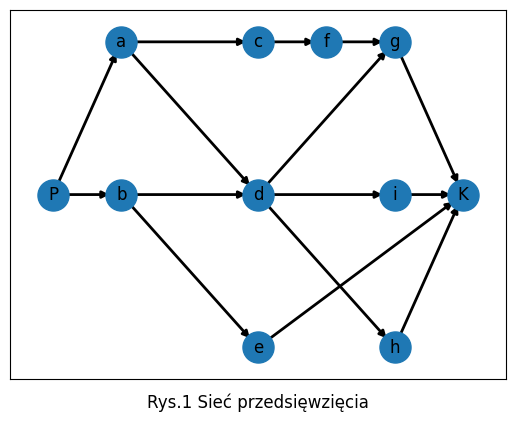

In [296]:
pozycja = {
    "P": (0, 1),
    "a": (1, 2),
    "b": (1, 1),
    "c": (3, 2),
    "e": (3, 0),
    "f": (4, 2),
    "h": (5, 0),
    "d": (3, 1),
    "i": (5, 1),
    "g": (5, 2),
    "K": (6, 1),
}
G = nx.DiGraph()
G.add_edges_from(Relacje)
nx.draw_networkx_nodes(G, pozycja, node_size=500)
nx.draw_networkx_labels(G, pozycja)
nx.draw_networkx_edges(
    G, pozycja, width=2, arrowsize=10, edge_color="black", arrows=True
)
plt.title(f"Rys.1 Sieć przedsięwzięcia",y=-0.10)
plt.show()

# Zadanie 2  <a name="z_2">
Zdefiniować zadanie programowania liniowego wyznaczające najwczejśniejszy termin zakończenia przedsięwzięcia i rozwiązać je. Uzyskane rozwiązanie zilustrować na wykresie Gantta.  

”’## Model matematyczny

### Zbiory
$Z \in N \cup T \cup K$ - zbór zadań plus sztuczne dwa zadania P-początek i K-koniec reprezentujące początek i zakończenie

$(i,j) \in R$ - zbiór par zadań będących w relacji poprzedzania, tj. przed zakończeniem zadania $i$ nie można rozpocząć zadania $j$

### Parametry
$t_i$ - czas wykonywania zadania $i$   

### Zmienne decyzyjne
$p_i$  - czas rozpoczęcia zadania $i$

### Funkcja celu
$$T_{min} = min(p_K + 0.0001 * \sum_{i \in Z}{p_i}) \quad (1)$$
Czasem minimalnym do wykonania zadań możemy określić rozpoczęcie ostatniego 'sztucznego' zadania K. Aby uniknąć niejednoznaczności do wyniku dodana jest suma zakończenia wszystkich zadaniań pomnożona przez baradzo małą liczbę zgodnie ze wskazówką w poleceniu.   

### Ograniczenia
$$p_i + t_i <= p_j, \forall_{(i,j)} \in R \quad (2)$$  
Początek wykowywania zadania $i$ plus jego czas wykonia nie może być większy niż początek wykonywania zadania $j$, gdzie zadanie $i$ jest zadaniem poprzedzającym zadanie $j$.  


## Implementacji AMPL with python API

In [297]:
%%ampl_eval

# sets
set Zadania;  # Zbiór zadań
set Relacje within {Zadania, Zadania}; # Zbior par elementow ze zbioru zadań

# params
param CzasTrwania {Zadania} >= 0; # Czas trwania zadań

# vars
var rozpoczecie {Zadania} >= 0; # Czas rozpoczęcia zadań

# constrains
subject to ogrPoprzedania {(i,j) in Relacje}:
  rozpoczecie[i] + CzasTrwania[i] <= rozpoczecie[j];  # zadanie j nie zacznie sie dopoki zadanie i sie nie zakonczy

# objectives
minimize Tmin: rozpoczecie["K"] + 0.0001 * sum{i in Zadania} rozpoczecie[i]; 
  # najmniejsza wartośc dla K sztuczengo zadania jest również czasem zakończenia ostatniego zadania.

In [298]:
# Load data
ampl.set["Zadania"] = Zadania
ampl.set["Relacje"] = Relacje
ampl.param["CzasTrwania"] = CzasTrwania

In [299]:
# Solve the problem
ampl.option["solver"] = "minos"
ampl.solve()

MINOS 5.51: optimal solution found.
6 iterations, objective 19.0072


In [300]:
Tmin = int(ampl.obj["Tmin"].value())

In [301]:
df = ampl.var["rozpoczecie"].to_pandas()
df["CzasTrwania"] = ampl.param["CzasTrwania"].to_pandas()["CzasTrwania"]
df = df.drop("K")
df = df.drop("P")
df.columns = ["RozpoczecieZadania", "CzasTrwaniaZadania"]
df.index.name = "Zadanie"
df_zad_2 = df
display(df, "Tabela. 1: Przedstawia czasy rozpoczęcia i trwania dla poszczególnych zadań")

,RozpoczecieZadania,CzasTrwaniaZadania
Zadanie,,
a,0,2
b,0,5
c,2,7
d,5,5
e,5,10
f,9,3
g,12,6
h,10,8
i,10,9


'Tabela. 1: Przedstawia czasy rozpoczęcia i trwania dla poszczególnych zadań'

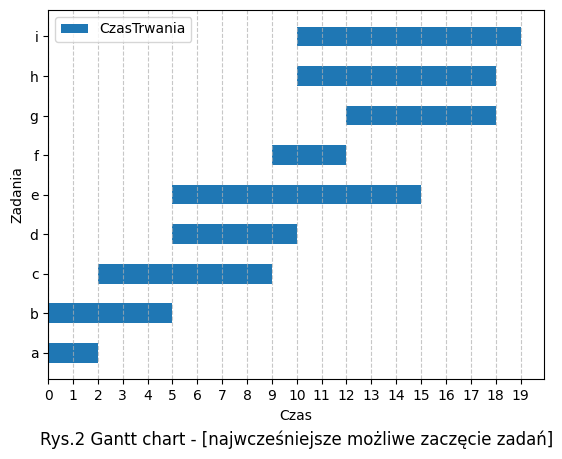

In [302]:
plt.barh(
    y=df.index,
    width=df["CzasTrwaniaZadania"],
    left=df["RozpoczecieZadania"],
    height=0.5,
)
plt.xticks(range(20))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Rys.2 Gantt chart - [najwcześniejsze możliwe zaczęcie zadań]", y=-0.20)
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.legend(["CzasTrwania"])
plt.show()

# Zadanie 3  <a name="z_3">
Przyjmując Tmin uzyskane z poprzedniego punktu jako termin zakończenia całego projektu, wyznaczyć harmonogram dla najpóźniejszych możliwych chwil rozpoczęcia zadań.

## Model matematyczny

Do Modelu matematycznego z podpunktu 2 został dodany jeden parametr oraz jedno ograniczenie oraz została zmieniona funckja celu:  


### Parametry
$Tmin$ - minimalny czas potrzebny do wykonania wszystkich zadań obliczony w podpunkcie 2  

### Ograniczenia
$$p_K <= Tmin \quad (3)$$ gdzie $p_K$ to czas rozpoczecia ostaniego 'sztucznego' zadania K. Dzieki temu ograniczeniu ustawiamy górną granice dla wykonia wszystkich zadań co pozwoli nam otrzymać odpowiedź na pytanie, kiedy najpóźniej można zacząć zadania, żeby nie opóźnić projektu.  

### Funkcja celu
$$T_{min} = max(p_K + 0.0001 * \sum_{i \in Z}{p_i}) \quad (4)$$
Funkcja celu (1) została zmodyfikowana aby otrzymać najpóźniejsze możliwe czasy rozpoczęcia zadań  

In [303]:
ampl.reset()

In [304]:
%%ampl_eval

# sets
set Zadania;  # Zbiór zadań
set Relacje within {Zadania, Zadania}; # Zbior par elementow ze zbioru zadań

# params
param CzasTrwania {Zadania} >= 0; # Czas trwania zadań
param Tmin; # Minimalny czas zakończenia ostaniego zadania

# vars
var rozpoczecie {Zadania} >= 0; # Czas rozpoczęcia zadań

# constrains
subject to ogrPoprzedania {(i,j) in Relacje}:
  rozpoczecie[i] + CzasTrwania[i] <= rozpoczecie[j];  # zadanie j nie zacznie sie dopoki zadanie i sie nie zakonczy

subject to ogrKoniec:
  rozpoczecie["K"] <= Tmin; 
    # Ograniczenie zapewniające że ostanie zadanie nie zostanie ukończone później
    #   niż minimalny czas zakończenia ostaniego zadania obliczony w porzednim podpukncie  

# objectives
maximize Tmax: rozpoczecie["K"] + 0.0001 * sum{i in Zadania} rozpoczecie[i];
    # najmniejsza wartośc dla K sztuczengo zadania

In [305]:
# Load data
ampl.set["Zadania"] = Zadania
ampl.set["Relacje"] = Relacje
ampl.param["CzasTrwania"] = CzasTrwania
ampl.param["Tmin"] = Tmin

In [306]:
ampl.option["solver"] = "minos"
ampl.solve()

MINOS 5.51: optimal solution found.
5 iterations, objective 19.0081


In [307]:
df = ampl.var["rozpoczecie"].to_pandas()
df["CzasTrwania"] = ampl.param["CzasTrwania"].to_pandas()["CzasTrwania"]
df.columns = ["RozpoczecieZadania", "CzasTrwaniaZadania"]
df.index.name = "Zadanie"
df_zad_3 = df
display(df, "Tabela. 2: Przedstawia czasy rozpoczęcia i trwania dla poszczególnych zadań. Dla przypadku rozpoczęcia zadań jak najpóźniej tylko możliwe")

,RozpoczecieZadania,CzasTrwaniaZadania
Zadanie,,
K,19.0,0
P,0.0,0
a,1.0,2
b,0.0,5
c,3.0,7
d,5.0,5
e,9.0,10
f,10.0,3
g,13.0,6


'Tabela. 2: Przedstawia czasy rozpoczęcia i trwania dla poszczególnych zadań. Dla przypadku rozpoczęcia zadań jak najpóźniej tylko możliwe'

## Obliczenie zapasu całkowitego

In [308]:
df_zapas_calkowity = df_zad_3["RozpoczecieZadania"] - df_zad_2["RozpoczecieZadania"]
df_zapas_calkowity.name = "Zapas Calkowity"
df_zapas_calkowity
df_zapas_calkowity.drop("K", inplace=True)
df_zapas_calkowity.drop("P", inplace=True)
display(df_zapas_calkowity, "Tabela. 3: Zapas całkowity dla poszczególnych zadań")

Zadanie
a    1.0
b    0.0
c    1.0
d    0.0
e    4.0
f    1.0
g    1.0
h    1.0
i    0.0
Name: Zapas Calkowity, dtype: float64

'Tabela. 3: Zapas całkowity dla poszczególnych zadań'

## Wyznaczenie zadań krytycznych

Związek między zadaniami krytycznymi a zapasami: Gdy dane zadanie ma zapas równy zero to jest zadaniem krytycznym.

In [309]:
zadania_krytyczne = []
for zad, val in df_zapas_calkowity.items():
    val = round(val, 0)
    if val == 0:
        zadania_krytyczne.append(zad)

print(
    f"Zadaniami krytycznymi dla tego projektu są {zadania_krytyczne}. Ich opóźnienie spowoduje opóźnienie całego projektu."
)

Zadaniami krytycznymi dla tego projektu są ['b', 'd', 'i']. Ich opóźnienie spowoduje opóźnienie całego projektu.


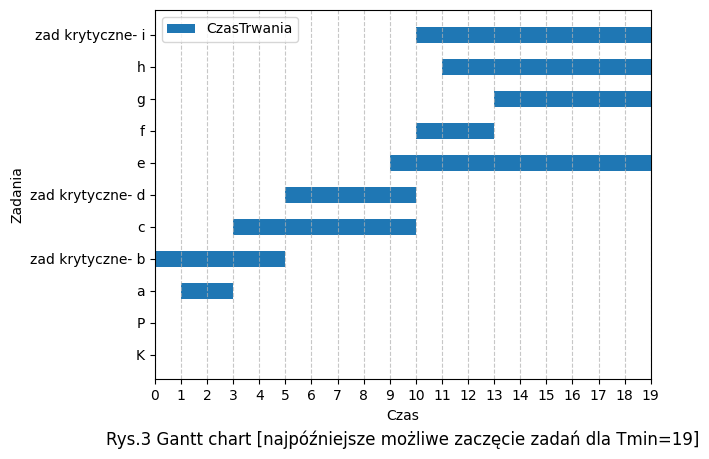

In [310]:
plt.barh(
    y=[x if x not in zadania_krytyczne else f'zad krytyczne- {x}' for x in df.index],
    width=df["CzasTrwaniaZadania"],
    left=df["RozpoczecieZadania"],
    height=0.5,
)
plt.xticks(range(20))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title(f"Rys.3 Gantt chart [najpóźniejsze możliwe zaczęcie zadań dla Tmin={Tmin}]", y=-0.20)
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.legend(["CzasTrwania"])
plt.show()

# Zadanie 4  <a name="z_4"> 
Wprowadzamy modyfikację w zadaniu planowania przedsięwzięcia. Każde z zadań można skrócić poprzez przydział dodatkowych środków. Przydzielając dodatkowe $\alpha_i$ środków skracam czas wykonania zadania i o 1 dzień. Każde zadanie ma minimalny czas wykonywania zadania $t_{min}$, poniżej którego się nie można skrócić. Zadany jest budżet na skracanie zadań. Przeformułować zadanie programowania liniowego z poprzednich punktów, aby uwzględnić możliwość skracania zadań. Rozwiązać problem i podać nowy harmonogram oraz czas trwania projektu. Dane do zadania 4 zostały wprowadzone zostały już wprowadzone.  

## Model matematyczny

### Zbiory
$Z \in N \cup T \cup K$ - zbór zadań plus sztuczne dwa zadania P-początek i K-koniec reprezentujące początek i zakończenie

$(i,j) \in R$ - zbiór par zadań będących w relacji poprzedzania, tj. przed zakończeniem zadania $i$ nie można rozpocząć zadania $j$

### Parametry
$t^{max}_i$ - maksymalny czas wykonywania zadania $i$  
$t^{min}_i$ - minimalny czas wykonywania zadania $i$  
$k_i$ - koszt skrócenia zadania $i$  
$d^{max}$ - maksymalne środki dostępne do skrócenia zadań  

### Zmienne decyzyjne
$p^{roz}_i$  - czas rozpoczęcia zadania $i$, gdzie $i$ jest integerem  
$p^{tr}_i$  - czas trwania zadania $i$, gdzie $i$ jest integerem  
$p^{sk}_i$  - czas skrócony zadania $i$,  gdzie $i$ jest integerem  

### Funkcja celu
$$T_{min} = min(p^{roz}_K + 0.0001 * \sum_{i \in Z}{p^{roz}_i}) \quad (5)$$
Czasem minimalnym do wykonania zadań możemy określić rozpoczęcie ostatniego 'sztucznego' zadania K. Aby uniknąć niejednoznaczności do wyniku dodana jest suma zakończenia wszystkich zadaniań pomnożona przez bardzo małą liczbę zgodnie ze wskazówką w poleceniu, sprawia to iż premiowane jest skracanie początkowych zadań.   

### Ograniczenia
$$p^{roz}_i + p^{tr}_i <= p^{roz}_j, \forall_{(i,j)} \in R \quad (6)$$  
Początek wykowywania zadania $i$ plus jego czas wykonia nie może być większy niż początek wykonywania zadania $j$, gdzie zadanie $i$ jest zadaniem poprzedzającym zadanie $j$.  

$$p^{tr}_i <= t^{max}_i, \forall_{i} \in R \quad (7)$$  
Czas trwania wykowania zadania $i$ nie może trwać dłużej niż maksymalna wartość podana w treści zadania  

$$p^{tr}_i >= t^{min}_i, \forall_{i} \in R \quad (8)$$  
Czas trwania wykowania zadania $i$ nie może trwać krócej niż minimalna wartość podana w treści zadania  

$$\sum_{i \in Z}{p^{sk}_i}*k_i <= d^{max} \quad (9)$$
Nie można wydać więcej środków do skracania niż zostało podane w zadaniu  

$$p^{tr}_i = t^{max}_i - p^{sk}_i, \forall_{i} \in R \quad (10)$$  
Relcja między czasem trwania zadania a skracaniem  


In [311]:
ampl.reset()

In [312]:
%%ampl_eval

# sets
set Zadania;  # Zbiór zadań
set Relacje within {Zadania, Zadania}; # Zbior par elementow ze zbioru zadań

# params
param MaxCzasTrwania {Zadania} >= 0; # Max Czas trwania zadań
param KosztSkracania {Zadania} >= 0; # koszt skracania o jedna jednostke czasu
param MinimalnyCzasTrwania {Zadania} >= 0; # Minimalny czas jaki zadanie moze być wykonywane, poniżej tej wartości nie można skrócić zadania
param SrodkiNaSkracanie;

# vars
var skracanie {Zadania} >= 0 integer; # o ile czasu zostało skrócone zadanie
var CzasTrwania {Zadania} >= 0; # Czas trwania zadania
var rozpoczecie {Zadania} >= 0 integer; # Czas rozpoczęcia zadań

# constrains
subject to ogrPoprzedania {(i,j) in Relacje}:
  rozpoczecie[i] + CzasTrwania[i] <= rozpoczecie[j];  # zadanie j nie zacznie sie dopoki zadanie i sie nie zakonczy

subject to ogrCzasTrwaniaMax {i in Zadania}:
  CzasTrwania[i] <= MaxCzasTrwania[i]; # Zadanie nie może trwać dłużej niż jego maxymalny czas trwania

subject to ogrCzasTrwaniaMin {i in Zadania}:
  CzasTrwania[i] >= MinimalnyCzasTrwania[i]; # Zadanie nie moze trwać krócej niż jego minilany czas trwania

subject to ogrSkracanie:
  sum{i in Zadania} skracanie[i] * KosztSkracania[i] <= SrodkiNaSkracanie; # Nie można wydać więęcej środków do skrania niz zdefinowane w zadaniu

subject to ogrCzasTrwaniaRelacjaSkracanie {i in Zadania}:
  CzasTrwania[i] = MaxCzasTrwania[i] - skracanie[i]; # Relcja między czasem trwania zadania a skracaniem  
 

# objectives
minimize Tmin: rozpoczecie["K"] + 0.0001 * sum{i in Zadania} rozpoczecie[i];  
    # najmniejsza wartośc dla K sztuczengo zadania
    # Suma 'czasu rozpoczecia' w funkcji celu premjuje skracanie początkowych zadań

In [313]:
# Load data
ampl.set["Zadania"] = Zadania
ampl.set["Relacje"] = Relacje
ampl.param["MaxCzasTrwania"] = CzasTrwania
ampl.param["MinimalnyCzasTrwania"] = MinimalnyCzasTrwania
ampl.param["KosztSkracania"] = KosztSkracania
ampl.param["SrodkiNaSkracanie"] = SrodkiNaSkracanie

In [314]:
ampl.option["solver"] = "cplex"  # cplex uwzglednia zmienne integer
ampl.solve()

CPLEX 22.1.1.0: optimal integer solution within mipgap or absmipgap; objective 16.0053
8 MIP simplex iterations
0 branch-and-bound nodes
absmipgap = 5e-05, relmipgap = 3.12397e-06


In [315]:
ampl.var["skracanie"].to_dict()
skrocone_zadania = { x:y for x, y in ampl.var["skracanie"].to_dict().items() if y>0}
suma_skrocownych_zadan = sum([ KosztSkracania[k]*v  for k, v in skrocone_zadania.items()])
reszta_srodkow_skracania = SrodkiNaSkracanie - suma_skrocownych_zadan
display(f"Zostało zużyte {suma_skrocownych_zadan} środków do skracania z {SrodkiNaSkracanie} możliwych. Zostało niewykorzystane: {reszta_srodkow_skracania} ")

'Zostało zużyte 11 środków do skracania z 12 możliwych. Zostało niewykorzystane: 1 '

In [316]:
df = ampl.var["rozpoczecie"].to_pandas()
df["CzasTrwania"] = ampl.var["CzasTrwania"].to_pandas()
df["skracanie"] = ampl.var["skracanie"].to_pandas()
df = df.drop("K")
df = df.drop("P")
df.columns = ["RozpoczecieZadania", "CzasTrwaniaZadania", "SkracanieZadania"]
df.index.name = "Zadanie"
df_zad_4 = df
display(df, "Tabela. 4: Czas rozpoczęcia, skrócenia, oraz trwania dla poszczególnych zadań")

,RozpoczecieZadania,CzasTrwaniaZadania,SkracanieZadania
Zadanie,,,
a,0,1,1
b,0,2,3
c,1,7,0
d,2,5,0
e,2,10,0
f,8,2,1
g,10,6,0
h,7,8,0
i,7,9,0


'Tabela. 4: Czas rozpoczęcia, skrócenia, oraz trwania dla poszczególnych zadań'

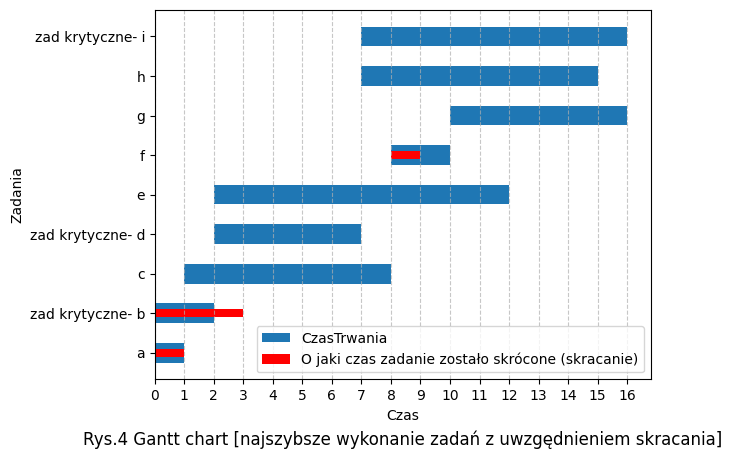

In [317]:
plt.barh(
    y=[x if x not in zadania_krytyczne else f'zad krytyczne- {x}' for x in df.index],
    width=df["CzasTrwaniaZadania"],
    left=df["RozpoczecieZadania"],
    height=0.5,
)
plt.xticks(range(20))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title(f"Rys.4 Gantt chart [najszybsze wykonanie zadań z uwzgędnieniem skracania]", y=-0.20)
plt.xlabel("Czas")
plt.ylabel("Zadania")
plt.barh(
    y=[x if x not in zadania_krytyczne else f'zad krytyczne- {x}' for x in df.index],
    width=df["SkracanieZadania"],
    left=df["RozpoczecieZadania"],
    height=0.2,
    color="red",
)
plt.legend(["CzasTrwania", "O jaki czas zadanie zostało skrócone (skracanie)"])
plt.show()

Czas trwania projektu po uwzględnieniu skracania wyniesie 16 jednostek czasu.  Powyżej znajduje się wyres Gantta przedstawiający harmonogram, wraz z wizualną reprezentacją gdzie zostało użyte skracanie. Ciekawą obserwacją jest to, że gdy do funkcji celu nie doda się członu $0.0001 * \sum_{i \in Z}{p^{roz}_i}$ wtedy inne zadania zostają skrócone, lecz nadal cały process kończy się w 16 jednostce czasu.    

# Dodatek A
pyproject.toml - zależności użyte w projekcie  

```
[tool.poetry]
name = "Zarzadzanie i harmonogramowanie procesow"
version = "1.0.0"
description = ""
authors = ["SzymonKwiecinski <01167477@pw.edu.pl> <kwiecinskji@gmail.com>"]
readme = "README.md"

[tool.poetry.dependencies]
python = "^3.11"
amplpy = "^0.12.2"
amplpy-cplex = "^0.1.5"
pandas = "^2.1.4"
jupyter = "^1.0.0"
ipykernel = "^6.27.1"
scipy = "^1.11.4"
nbconvert = { extras = ["webpdf"], version = "^7.14.1" }
black = { extras = ["jupyter"], version = "^23.12.1" }
pip = "^23.3.2"
numpy = "^1.26.4"
matplotlib = "^3.8.3"
networks = "^0.3.7"
networkx = "^3.2.1"
python-dotenv = "^1.0.1"


[build-system]
requires = ["poetry-core"]
build-backend = "poetry.core.masonry.api"
```